# **Text summarization with Attention**
- abstractive summarization
- used Amazon review data(download : https://www.kaggle.com/snap/amazon-fine-food-reviews)

## **1. Understanding Amazon review data**

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [4]:
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU')]

### 1.1 Load Data

In [12]:
data = pd.read_csv("./dataset/Reviews.csv", nrows=100000)    # use only 100000 data
print('The number of total review : ', len(data))

The number of total review :  100000


In [13]:
data.head() # print 5 samples

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


- Don't need all attributes
- Extract Text, Summary only

In [14]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [15]:
# randomly print 10 sample data
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


### 1.2 Data refining

Check whether repetitive samples are exist

In [16]:
print('The number of unique sample in Text column : ', data['Text'].nunique())
print('The number of unique sample in Summary column : ', data['Summary'].nunique())

The number of unique sample in Text column :  88426
The number of unique sample in Summary column :  72348


About 1200 Text samples are repetitive.  
Summary may be repetitive though original text is different.  
So, let's just remove duplicates of Text attribute

In [17]:
data.drop_duplicates(subset=['Text'], inplace=True)
print('The number of total samples : ', len(data))

The number of total samples :  88426


Now check whether Null samples are exist!

In [18]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


1 null data in Summary is found. Let's remove this.

In [19]:
data.dropna(axis=0, inplace=True)
print('The number of total samples:', len(data))

The number of total samples: 88425


Now we have to preprocess each samples.
- Word normalization
- Remove stopwords

In [30]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [21]:
# stopwords in NLTK
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print('# of stopwords : ', len(stop_words))
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tkddnjs1234/nltk_data...


# of stopwords :  179
{'m', 'only', 'shouldn', 'me', 'did', 'itself', 'ourselves', 'y', "weren't", 'themselves', 'its', 'mightn', 'weren', 'he', 'this', 'off', 'while', "hasn't", 'will', 'which', 'is', "didn't", 'against', 'ain', 'don', "aren't", 's', 'now', 'it', 'those', 'each', 'up', 'again', 'too', "shan't", 'not', 'are', 'by', 'few', 'a', 'yourself', 'other', 'yourselves', 'until', 'being', "shouldn't", 'through', 'himself', 'your', 'has', 'when', 'below', 'out', 'nor', 've', 'doing', 'am', 'and', 'over', 'yours', 're', 'been', "you're", 'just', 'mustn', 'should', 'her', 'why', 'same', "it's", 'who', 'down', "mustn't", 'once', 'with', 'such', "wouldn't", 'most', 'at', 'then', 'if', 'what', 'between', 'into', 'you', 'didn', 'the', 'all', 'during', 'couldn', 'wasn', 'we', 'above', 'both', 'whom', 'very', 'she', "she's", 'hadn', 'them', 'haven', 'o', 'myself', 'how', 'an', "wasn't", 'do', 'of', 'aren', 'some', "you'd", 'to', 'where', 'than', 'can', 'after', "mightn't", 'shan', "haven

[nltk_data]   Unzipping corpora/stopwords.zip.


Make preprocessing function

In [24]:
! pip install lxml

     |████████████████████████████████| 6.3 MB 7.5 MB/s            


In [31]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence=sentence.lower()
    sentence=BeautifulSoup(sentence, 'html.parser').text   # remove html tag
    sentence=re.sub(r'\([^)]*\)', '', sentence) # EX) my husband (and myself) for => my husband for
    sentence=re.sub('"','', sentence)   # remove "
    sentence=' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])   # 약어 정규화
    sentence=re.sub(r"'s\b", "", sentence)  # EX) roland's => roland
    sentence=re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence=re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경 EX) ummmmmm yeah => umm yeah
    
    # remove stopword from 'Text'
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens    

In [32]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))   # remove stopwords
print(preprocess_sentence(temp_summary, 0)) # don't remove stopwords

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


Preprocess Text column

In [33]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]
    

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

Preprocess Summary column

In [34]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s,0))
clean_summary[:5]

/home/tkddnjs1234/anaconda3/envs/nlp-tutorial/lib/python3.6/site-packages/bs4/__init__.py:438: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

Save preprocessed result to data frame

In [35]:
data['Text'] = clean_text
data['Summary'] = clean_summary

Check wheter there are Null values after preprocessing.

In [36]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


70 samples in Summary became Null after preprocessing. Remove these.

In [37]:
data.dropna(axis=0, inplace=True)
print('# of total samples : ', len(data))

# of total samples :  88355


Visualize length distribution of Text, Summary

Min len of text : 2
Max len of text : 1235
Mean len of text : 38.79238300039613
Min len of summary : 1
Max len of summary : 28
Mean len of summary : 4.01075207967857


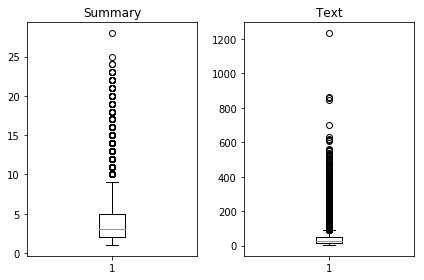

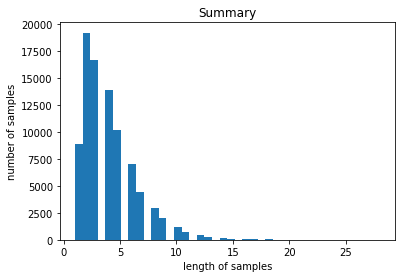

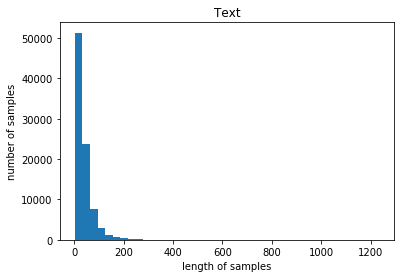

In [39]:
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('Min len of text : {}'.format(np.min(text_len)))
print('Max len of text : {}'.format(np.max(text_len)))
print('Mean len of text : {}'.format(np.mean(text_len)))
print('Min len of summary : {}'.format(np.min(summary_len)))
print('Max len of summary : {}'.format(np.max(summary_len)))
print('Mean len of summary : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


Most original Text's length is under 100. Mean length is 38.  
Most Summary's length is under 15. Mean length is 4.  
Decide the length of padding 50, 8 which is slightly larger than mean length.

In [40]:
text_max_len = 50
summary_max_len = 8

Check how long these two length in samples.

In [41]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt += 1
    print("Percentage of samples that length is under %s : %s"%(max_len, (cnt/len(nested_list))))

Check for Text column

In [43]:
below_threshold_len(text_max_len, data['Text'])

Percentage of samples that length is under 50 : 0.774523230151095


About 77% samples have Text length under 50 and 23% samples have length over 50.  
Let's check for Summary column.

In [44]:
below_threshold_len(summary_max_len, data['Summary'])

Percentage of samples that length is under 8 : 0.9424593967517402


About 94% samples have Summary length under 8.  
Remove samples that have length longer than max length.

In [45]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('# of total samples :', len(data))

# of total samples : 65819


In [46]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


For seq2seq training, add start token(sostoken) and end token(eostoken).

In [47]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [48]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 1.3 Data seperation

Split train/test data.  
First, make suffled integer sequence.

In [49]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[61167 60940 49478 ... 45440 26023  1298]


Use this sequence order as data sample order to use shuffled data.

In [88]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

Split data into 8:2 = train:test

In [89]:
n_of_val = int(len(encoder_input)*0.2)
print('# of test data :', n_of_val)

# of test data : 13163


In [90]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [91]:
print('# of train data :', len(encoder_input_train))
print('# of train label :',len(decoder_input_train))
print('# of test data :',len(encoder_input_test))
print('# of test label :',len(decoder_input_test))

# of train data : 52656
# of train label : 52656
# of test data : 13163
# of test label : 13163


### 1.4 Integer encoding

Encode train/test data to integer so that machine can process text.  
Make vocab of train data.  

In [92]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

Now vocab has been made and unique integer value is assigned to each word.  
This is stored in src_tokenizer.word_index.  
Here, we ignore low frequent word.  
Check the percentage of words that has frequency lower than 7.

In [93]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)   # the number of words
rare_cnt = 0    # count the words that has frequency lower than threshold
total_freq = 0  # sum of total words freq in train data
rare_freq = 0   # sum of rare words freq

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32100
등장 빈도가 6번 이하인 희귀 단어의 수: 23858
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8242
단어 집합에서 희귀 단어의 비율: 74.3239875389408
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.398866703535907


Let's ignore words that have freq lower than 7 while encoding.  
For simplicity limit vocab size to 8000

In [94]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# change text seq to integer seq
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)


In [95]:
print(encoder_input_train[:3])

[[107, 2837, 1111, 2221, 741, 3250, 864, 2594, 581, 2569, 31, 73, 7, 20, 895, 99, 5, 1, 908, 2345, 75, 289, 31, 672, 38, 329, 279, 3550, 5106, 932, 169, 337, 1, 108, 5], [2787, 1009, 1136, 1921, 832, 4082, 643, 28, 121, 283, 17], [3, 911, 3, 501, 56, 1293, 13, 209, 991, 2013, 5107]]


Process Summary data too.

In [96]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [97]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10525
등장 빈도가 5번 이하인 희귀 단어의 수: 8149
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2376
단어 집합에서 희귀 단어의 비율: 77.4251781472684
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.947150780776


In [98]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [99]:
# change text seq to integer seq
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [100]:
print(decoder_input_train[:5])

[[1, 687], [1], [1, 987], [1, 4, 303], [1, 212, 168]]


In [101]:
print(decoder_target_train[:5])

[[24, 991, 2], [72, 89, 259, 7, 5, 31, 2], [3, 66, 10, 4, 704, 22, 484, 2], [8, 99, 34, 2], [11, 95, 109, 6, 139, 12, 2]]


### 1.5 Remove empty samples

Check whether there are empty samples after removing low frequency words.  
Note that we added sostoken to decoder_input and eostoken to decoder_target.  
These two token is added to all samples so this word is not low frequent word.(i.e. these are not removed)
So, empty sample's actual length is 1 not 0!


In [102]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1] 

In [103]:
print('# of train data to remove :', len(drop_train))
print('# of test data to remove :', len(drop_test))

# of train data to remove : 1295
# of test data to remove : 294


In [104]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 51361
훈련 레이블의 개수 : 51361
테스트 데이터의 개수 : 12869
테스트 레이블의 개수 : 12869


### 1.6 Padding

In [105]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## **2. Build seq2seq + attention model & Train**

In [106]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Build Encoder using 3 LSTM layers.

In [107]:
embedding_dim = 128
hidden_size = 256

# encoder
encoder_inputs = Input(shape=(text_max_len,))

# embedding layer in encoder
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

Build decoder.  
Decoder is similar to Encoder except that it's initial state is encoder state.

In [108]:
# decoder
decoder_inputs = Input(shape=(None,))

# decoder embedding layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# model definition
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

Use attention mechanism to output layer.  
First, download attention.py thru github.

In [109]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

Build new decoder output layer using attention.

In [110]:
# attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# concat attention result with decoder hidden state
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# model definition
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [111]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Set early stopping condition and train model

In [112]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [113]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Train on 51361 samples, validate on 12869 samples
Epoch 1/50
28672/51361 [===============>..............] - ETA: 23s - loss: 3.0851

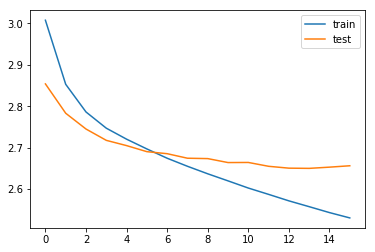

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **3. Test model**

Make 3 dictionary for test

In [79]:
src_index_to_word = src_tokenizer.index_word # integer -> word(original text)
tar_word_to_index = tar_tokenizer.word_index # word -> integer(summary)
tar_index_to_word = tar_tokenizer.index_word # integer -> word(summary)

Seq2seq model's operation in train and test is different.
We have to re-build model for test.

In [80]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

Now build test decoder.

In [81]:
# tensor to save previous state
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [82]:
# attention function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# decoder output layer
decoder_output2 = decoder_softmax_layer(decoder_inf_concat)

# last decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)


Now we build model for test.  
Make decode_sequence function for test.

In [84]:
def decode_sequence(input_seq):
    # get encoder state from input
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # make <SOS> token
    target_seq = np.zeros((1,1))
    target_seq[0,0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:   # loop until stop_condition become True
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1 :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        
        # stop when reach <eos> or exceeed max length
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1):
            stop_condition = True
        
        # update target seq that has length 1
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        # update state
        e_h, e_c, = h, c
    
    return decoded_sentence

To compare original text with actual summary and predicted summary, make function that change integer seq into text seq.

In [85]:
# change original text's integer seq into text seq
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if i!=0:
            sentence += src_index_to_word[i]+' '
    return sentence

# change summary's integer seq into text seq
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence += tar_index_to_word[i] + ' '
    return sentence

In [87]:
# test for sample 500~1000
for i in range(500, 1000):
    print(f"============Result {i}============")
    print("Original : ",seq2text(encoder_input_test[i]))
    print("Actual Summary :",seq2summary(decoder_input_test[i]))
    print("Predicted Summary :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

============Result 500============
Original :  cookies pretty good like much like ones close second girl scouts good cookies always fan cookies everyone get box two support 
Actual Summary : great tea 
Predicted Summary :  one small small in in wow wow


============Result 501============
Original :  thought deal realize walmart better deal live learn great product baking 
Actual Summary : fantastic quality and taste 
Predicted Summary :  one small small am am in on


============Result 502============
Original :  bought coffeemaker tried several different brands types coffee one become stable count great cup coffee strong mild way like drink coffee probably taste downside 
Actual Summary : good but not great 
Predicted Summary :  and and and am am am dog


============Result 503============
Original :  hoping true granulated garlic pulverized powder well bit disappointed received powder reason wanted true granules retain garlic much longer powder year take use think flavor gone unlike